In [1]:
import os
import sys
sys.path.append("../")
sys.path.append("../../")
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np

from data_utils import *

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from acp import *

## ACP sur les proportions

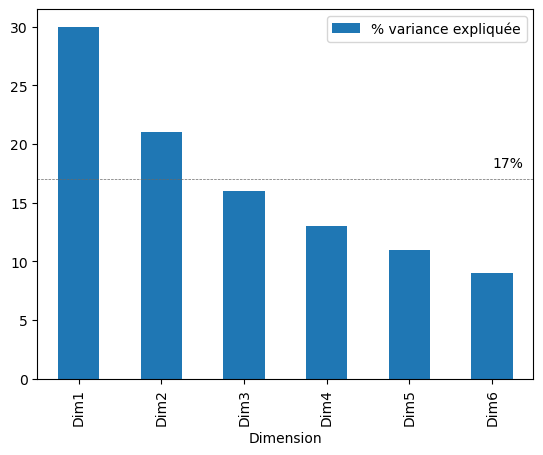

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            1.776507                  30.0                   30.0
1      Dim2            1.267228                  21.0                   51.0
2      Dim3            0.985160                  16.0                   67.0
3      Dim4            0.799718                  13.0                   80.0
4      Dim5            0.633279                  11.0                   91.0
5      Dim6            0.538836                   9.0                  100.0
8232


In [2]:
### SCRIPT ###

edges_all_prop_path = "../../../score_calculation/sample_analyse/sample_data/edges_all_prop_sample.gpkg"
edges_all_prop_output_path = "../../../score_calculation/sample_analyse/sample_data/edges_all_prop_sample_hclust.gpkg"
edges_all_prop = gpd.read_file(edges_all_prop_path)
features = ["prairies_prop", "arbustes_prop", "arbres_prop", "C_wavg_scaled", "eaux_prop", "canop"]

prop_pca = pca_pipeline(edges_all_prop, features, 6)
eig_prop_pca = eigein_values(prop_pca, plot=True)
coord = coord_pca(edges_all_prop[features], prop_pca)
print(len(coord)) # 8232

In [3]:
prop_pca.explained_variance_ratio_

array([0.29604858, 0.21117905, 0.16417336, 0.13327021, 0.10553372,
       0.08979506])

In [4]:
def plot_ind_pca(data, pca, nbre_dim=2, method="plotly", dim=[1, 2], color=None):
    coord = coord_pca(data, pca)[:,0:nbre_dim]
    if(method == "plotly"):
        labels = {
            str(i): f"PC {i+1} ({var:.1f}%)"
            for i, var in enumerate(pca.explained_variance_ratio_[:nbre_dim] * 100)
        }

        fig = px.scatter_matrix(
            coord,
            labels=labels,
            dimensions=range(nbre_dim),
            color=color
        )
        fig.update_traces(diagonal_visible=False)
        fig.show()
    
    elif(method == "raw_plt"):
        coord_df = pd.DataFrame({
            f"Dim{dim[0]}" : coord[:, dim[0]-1],
            f"Dim{dim[1]}": coord[:, dim[1]-1]
        })
        coord_df.plot.scatter(f"Dim{dim[0]}", f"Dim{dim[1]}", c=color)
        plt.xlabel(f"Dimension {dim[0]} {round(pca.explained_variance_ratio_[dim[0]-1]*100, 2)}%")
        plt.ylabel(f"Dimension {dim[1]} {round(pca.explained_variance_ratio_[dim[1]-1]*100, 2)}%")
        plt.show()

In [5]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=3)

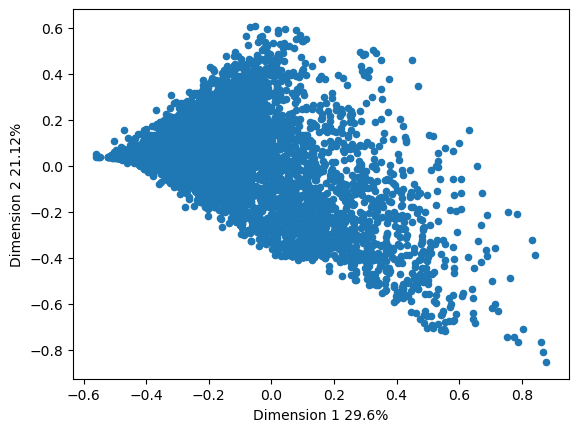

In [6]:
plot_ind_pca(edges_all_prop[features], prop_pca, method="raw_plt", dim=[1,2])

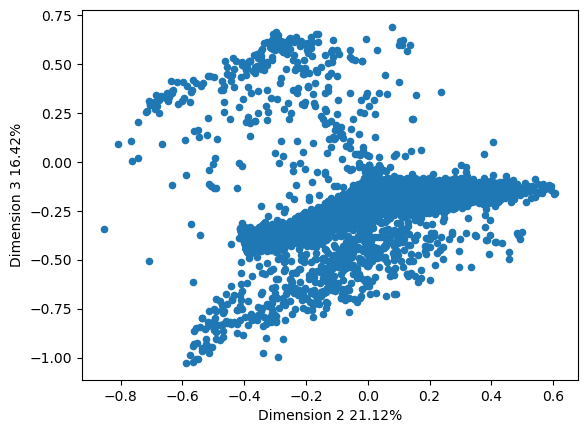

In [7]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=3, method="raw_plt", dim=[2,3])

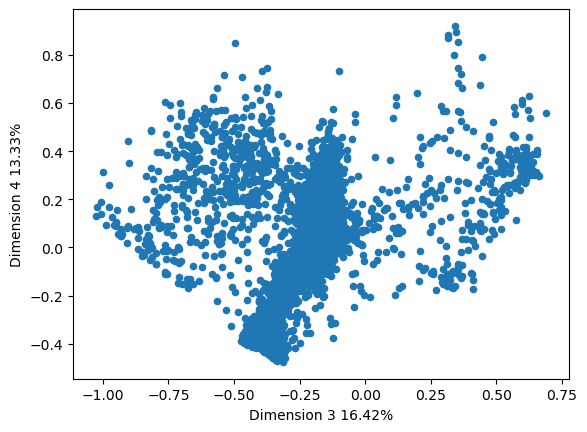

In [8]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=4, method="raw_plt", dim=[3,4])

In [9]:
def coord_var_pca(data, pca, dim=[1,2]):
    n = data.shape[0]
    p = data.shape[1]
    eigval = (n-1)/n * pca.explained_variance_
    sqrt_eigval = np.sqrt(eigval)
    corvar = np.zeros((p,p))
    for k in range(p):
        corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
    
    coordvar = pd.DataFrame({"id": data.columns, "COR_1": corvar[:,dim[0]-1], "COR_2": corvar[:,dim[1]-1]})

    return coordvar

In [10]:
def plot_var_circle(coordvar):
    # Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
    fig, axes = plt.subplots(figsize = (6,6))
    fig.suptitle("Cercle des corrélations")
    axes.set_xlim(-1, 1)
    axes.set_ylim(-1, 1)
    # Ajout des axes
    axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
    axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
    # Ajout des noms des variables
    for j in range(coordvar.shape[0]):
        axes.text(coordvar["COR_1"][j]+0.05,coordvar["COR_2"][j]+0.05, f"{coordvar['id'][j]} ({round(coordvar['COR_1'][j], 2)}, {round(coordvar['COR_2'][j], 2)})")
        axes.arrow(0,0,
                 coordvar["COR_1"][j],
                 coordvar["COR_2"][j],
                 lw = 2, # line width
                 length_includes_head=True, 
                 head_width=0.05,
                 head_length=0.05
                  )
    # Ajout du cercle
    plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

    plt.show()


              id     COR_1     COR_2
0  prairies_prop  0.450012 -0.012299
1  arbustes_prop  0.412062 -0.029642
2    arbres_prop  0.552038 -0.314447
3  C_wavg_scaled -0.786128 -0.218730
4      eaux_prop  0.462167  0.700692
5          canop  0.517343 -0.588491


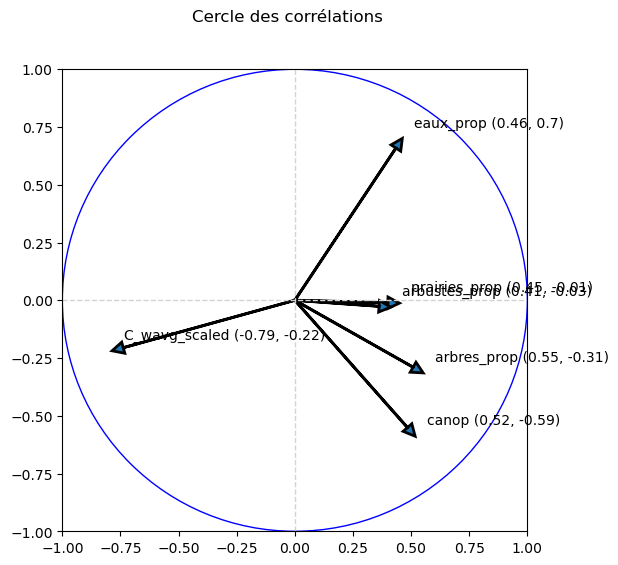

In [11]:
print(coord_var_pca(edges_all_prop[features], prop_pca, dim=[1,3]))
plot_var_circle(coord_var_pca(edges_all_prop[features], prop_pca, dim=[1,3]))

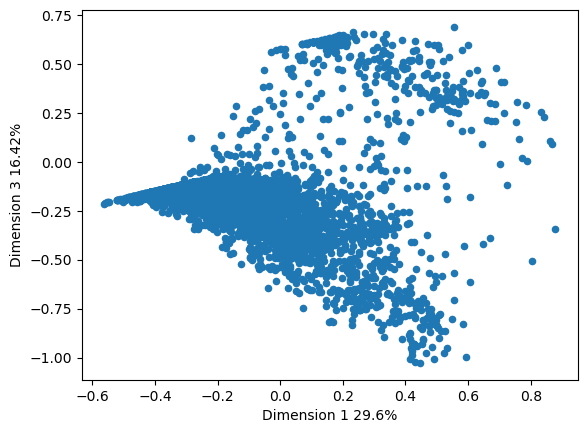

In [12]:
plot_ind_pca(edges_all_prop[features], prop_pca, nbre_dim=3, method="raw_plt", dim=[1,3])

In [13]:
def hclust_on_acp(data, pca, dt=0, n=None):
    hac = AgglomerativeClustering(distance_threshold=dt, n_clusters=n)
    pca_data = pca.transform(data)

    return(hac.fit(pca_data))

In [14]:
def plot_dendrogram(model, **kwargs):
    """Ne fonctionne que si distance_threshold != None donc n_clusters=None"""
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [15]:
hclust = hclust_on_acp(edges_all_prop[features], prop_pca, dt=None, n=3)
#plt.title("Hierarchical Clustering Dendrogram")
#plot_dendrogram(hclust, truncate_mode="level", p=3)
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.show()

In [16]:
pd.Series(hclust.labels_).value_counts()

1    6062
0    1865
2     305
dtype: int64

In [17]:
prop_pca_coord = coord_pca(edges_all_prop[features], prop_pca)
print(prop_pca_coord)
prop_pca_coord_df = pd.DataFrame(prop_pca_coord, columns=[f"Dim {i}" for i in range(1,7)])

print(prop_pca_coord_df)

[[-0.38200985  0.02632052 -0.1427317   0.11117968  0.02241395 -0.48947602]
 [-0.48609973  0.03349232 -0.18162317  0.14147387  0.02852129 -0.62284823]
 [-0.0521706   0.05114181 -0.22720597 -0.09577323 -0.12909845 -0.57718253]
 ...
 [-0.06989409 -0.11735628 -0.22805109 -0.13304086 -0.14654437 -0.50281805]
 [-0.34731322  0.02392992 -0.12976788  0.10108162  0.02037817 -0.44501862]
 [-0.17087413 -0.03496363 -0.23276304  0.00201802 -0.18902958 -0.58794374]]
         Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6
0    -0.382010  0.026321 -0.142732  0.111180  0.022414 -0.489476
1    -0.486100  0.033492 -0.181623  0.141474  0.028521 -0.622848
2    -0.052171  0.051142 -0.227206 -0.095773 -0.129098 -0.577183
3    -0.266847  0.161899 -0.133091  0.187317 -0.098867 -0.485303
4     0.264879 -0.047048 -0.117530 -0.051312 -0.364889 -0.593284
...        ...       ...       ...       ...       ...       ...
8227 -0.454526  0.031317 -0.169826  0.132285  0.026669 -0.582392
8228 -0.320105  0.055327

In [18]:
data_pca_hclust = prop_pca_coord_df.assign(hclust_classe = hclust.labels_.astype(str))
data_pca_hclust 

Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6 hclust_classe
0    -0.382010  0.026321 -0.142732  0.111180  0.022414 -0.489476             1
1    -0.486100  0.033492 -0.181623  0.141474  0.028521 -0.622848             1
2    -0.052171  0.051142 -0.227206 -0.095773 -0.129098 -0.577183             0
3    -0.266847  0.161899 -0.133091  0.187317 -0.098867 -0.485303             1
4     0.264879 -0.047048 -0.117530 -0.051312 -0.364889 -0.593284             0
...        ...       ...       ...       ...       ...       ...           ...
8227 -0.454526  0.031317 -0.169826  0.132285  0.026669 -0.582392             1
8228 -0.320105  0.055327 -0.166673  0.094000 -0.032580 -0.535669             1
8229 -0.069894 -0.117356 -0.228051 -0.133041 -0.146544 -0.502818             0
8230 -0.347313  0.023930 -0.129768  0.101082  0.020378 -0.445019             1
8231 -0.170874 -0.034964 -0.232763  0.002018 -0.189030 -0.587944             0

[8232 rows x 7 columns]

In [19]:
print(data_pca_hclust[["Dim 1", "Dim 2", "hclust_classe"]])
print(data_pca_hclust.columns)
data_pca_hclust[["hclust_classe"]]

         Dim 1     Dim 2 hclust_classe
0    -0.382010  0.026321             1
1    -0.486100  0.033492             1
2    -0.052171  0.051142             0
3    -0.266847  0.161899             1
4     0.264879 -0.047048             0
...        ...       ...           ...
8227 -0.454526  0.031317             1
8228 -0.320105  0.055327             1
8229 -0.069894 -0.117356             0
8230 -0.347313  0.023930             1
8231 -0.170874 -0.034964             0

[8232 rows x 3 columns]
Index(['Dim 1', 'Dim 2', 'Dim 3', 'Dim 4', 'Dim 5', 'Dim 6', 'hclust_classe'], dtype='object')


hclust_classe
0                1
1                1
2                0
3                1
4                0
...            ...
8227             1
8228             1
8229             0
8230             1
8231             0

[8232 rows x 1 columns]

In [20]:
def plot_coord_class(data, hclust_coord, pca=None, nbre_dim=2, method="plotly", dim=[1, 2], colors=None):
    if(method == "plotly"):
        fig = px.scatter_matrix(
            data[:,0:nbre_dim],
            labels=hclust_coord[0:nbre_dim],
            dimensions=range(nbre_dim),
            color=hclust_coord["hclust_classe"].astype(str),
            color_discrete_map=colors
        )
        fig.update_traces(diagonal_visible=False)
        fig.show()
    
    elif(method == "raw_plt"):
        coord_df = pd.DataFrame({
            f"Dim{dim[0]}" : data[:, dim[0]-1],
            f"Dim{dim[1]}": data[:, dim[1]-1],
            "color": hclust_coord["hclust_classe"].astype(int)
        })
        coord_df.plot.scatter(f"Dim{dim[0]}", f"Dim{dim[1]}", c="color", cmap=colors)
        plt.xlabel(f"Dimension {dim[0]} {round(pca.explained_variance_ratio_[dim[0]-1]*100, 2)}%")
        plt.ylabel(f"Dimension {dim[1]} {round(pca.explained_variance_ratio_[dim[1]-1]*100, 2)}%")
        plt.show()

In [21]:
class_colors = {
    "0": "blue",
    "1": "red",
    "2": "green"
}

In [23]:
#plot_coord_class(prop_pca_coord, data_pca_hclust, pca=prop_pca, nbre_dim=3, method="raw_plt", colors=class_colors)

In [22]:
plot_coord_class(prop_pca_coord, data_pca_hclust, nbre_dim=3, method="plotly")

Première analyse : 
Dim 1 anti corrélée à la température, 3 groupes en fonction de la température ? (regarder si différence significative avec test de student
Dim 2 : corrélée proporotion Arbustes, prairies et un peu arbres
Dim 3 : corrélée eaux

Analyse classification : sur la première dimension, 3 groupes en fonction de la température (à confirmer par test de student)
Si on regarde peut être classif en fonction des arbres. 

Conclusion générale ACP : peu de réduction de dimension => les variables n'étant pas très corrélés, semble pertinent de plutôt toutes les garder. Par contre on voit plusieurs tendances. L'ACP nous permet une analyse descriptive de notre population de segments. 

Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6 hclust_classe
0    -0.382010  0.026321 -0.142732  0.111180  0.022414 -0.489476             1
1    -0.486100  0.033492 -0.181623  0.141474  0.028521 -0.622848             1
2    -0.052171  0.051142 -0.227206 -0.095773 -0.129098 -0.577183             0
3    -0.266847  0.161899 -0.133091  0.187317 -0.098867 -0.485303             1
4     0.264879 -0.047048 -0.117530 -0.051312 -0.364889 -0.593284             0
...        ...       ...       ...       ...       ...       ...           ...
8227 -0.454526  0.031317 -0.169826  0.132285  0.026669 -0.582392             1
8228 -0.320105  0.055327 -0.166673  0.094000 -0.032580 -0.535669             1
8229 -0.069894 -0.117356 -0.228051 -0.133041 -0.146544 -0.502818             0
8230 -0.347313  0.023930 -0.129768  0.101082  0.020378 -0.445019             1
8231 -0.170874 -0.034964 -0.232763  0.002018 -0.189030 -0.587944             0

[8232 rows x 7 columns]

In [23]:
data_classif = data_pca_hclust
edges_all_prop["hclust_classe"] = data_pca_hclust["hclust_classe"]
print(edges_all_prop)

#edges_all_prop.to_file(edges_all_prop_output_path)

               u            v  key                   osmid  oneway  \
0     8479325439  10728498581    0               912794978   False   
1     4133578169   4133583310    0               411745302    True   
2     7346713200   7695862707    0               230400474    True   
3      758910910    758910868    0                60644310   False   
4     6055932133   3018201673    0               643533068   False   
...          ...          ...  ...                     ...     ...   
8227  4065130408   4065130414    0                18490430    True   
8228  1584921933    271230254    0  [962218617, 962222781]   False   
8229   394845549    394845537    0                50438836   False   
8230    32318145   5096240423    0                 4924151   False   
8231  1038572961   1038573089    0                89603961   False   

                       name      highway maxspeed reversed  length  ...  \
0                                footway              True  15.897  ...   
1        

In [30]:
print(edges_all_prop.columns)

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'prairies_prop', 'arbustes_prop', 'arbres_prop', 'C_wavg_scaled',
       'eaux_prop', 'canop', 'geometry', 'hclust_classe'],
      dtype='object')


## Plot temperature

In [32]:
temp_path = "./output_data/network/edges/edges_buffered_temp_wavg_bounding.gpkg"
temp = gpd.read_file(temp_path)

In [33]:
print(temp.columns)

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'C_wavg', 'C_wavg_scaled', 'geometry'],
      dtype='object')


In [34]:
edges_all_prop = edges_all_prop.set_index(["u", "v", "key"])
temp = temp.set_index(["u", "v", "key"])

In [35]:
sample_indices = edges_all_prop.index
print(sample_indices)

MultiIndex([(8479325439, 10728498581, 0),
            (4133578169,  4133583310, 0),
            (7346713200,  7695862707, 0),
            ( 758910910,   758910868, 0),
            (6055932133,  3018201673, 0),
            ( 412399792,  3749373440, 0),
            (5172894377,  5172894375, 0),
            (2466612684,  9604460784, 0),
            (4133474326,  6810171633, 0),
            (  86106001,    98302208, 0),
            ...
            (3188129607,  1383193492, 0),
            ( 641451683,   662976245, 0),
            (3476048540,  3476048538, 0),
            ( 193594802,  5737247356, 0),
            (9839155528,  9839155529, 0),
            (4065130408,  4065130414, 0),
            (1584921933,   271230254, 0),
            ( 394845549,   394845537, 0),
            (  32318145,  5096240423, 0),
            (1038572961,  1038573089, 0)],
           names=['u', 'v', 'key'], length=8232)


In [36]:
sample_temp = temp.loc[sample_indices]

In [50]:
edges_all_prop["C_wavg"] = sample_temp["C_wavg"]

780

In [53]:
edges_all_prop["hclust_classe"] = edges_all_prop["hclust_classe"].astype(str)
print(edges_all_prop["hclust_classe"])

edges_all_prop = edges_all_prop.dropna()

u           v            key
8479325439  10728498581  0      1
4133578169  4133583310   0      1
7346713200  7695862707   0      0
758910910   758910868    0      1
6055932133  3018201673   0      0
                               ..
4065130408  4065130414   0      1
1584921933  271230254    0      1
394845549   394845537    0      0
32318145    5096240423   0      1
1038572961  1038573089   0      0
Name: hclust_classe, Length: 8232, dtype: object


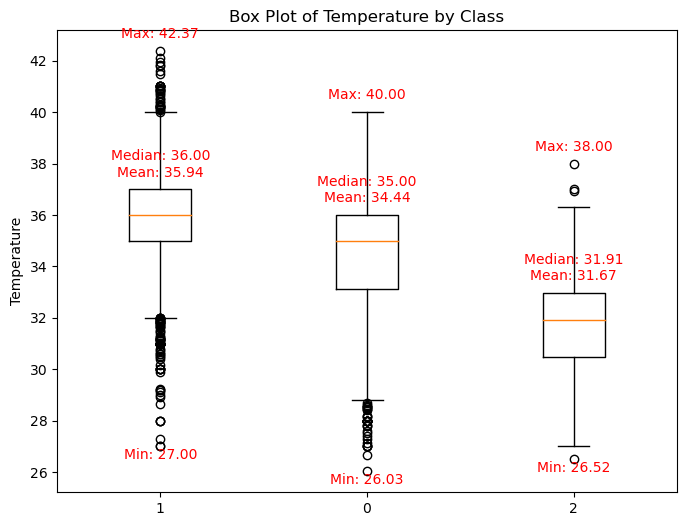

In [67]:
class_column = edges_all_prop['hclust_classe']
temperature_column = edges_all_prop['C_wavg']

# Create a dictionary to group the temperatures by class
temperature_by_class = {}
for cls, temp in zip(class_column, temperature_column):
    if cls not in temperature_by_class:
        temperature_by_class[cls] = []
    temperature_by_class[cls].append(temp)

# Calculate summary statistics for each class
statistics = {}
for cls, temps in temperature_by_class.items():
    statistics[cls] = pd.Series(temps).describe()

# Set the figure size to a smaller dimension
plt.figure(figsize=(8, 6))

# Create the box plot
plt.boxplot(temperature_data)

# Set the x-axis labels to the class names
plt.xticks(range(1, len(temperature_by_class) + 1), temperature_by_class.keys())

# Set the y-axis label
plt.ylabel('Temperature')

# Set the plot title
plt.title('Box Plot of Temperature by Class')

# Add the summary statistics to the plot
for i, cls in enumerate(temperature_by_class.keys()):
    stat = statistics[cls]

    plt.text(i + 1, stat['75%'] + 0.5, f'Median: {stat["50%"]:.2f}\nMean: {stat["mean"]:.2f}',
             horizontalalignment='center', color='red')

    plt.text(i + 1, stat['max'] + 0.5, f'Max: {stat["max"]:.2f}',
             horizontalalignment='center', color='red')

    plt.text(i + 1, stat['min'] - 0.5, f'Min: {stat["min"]:.2f}',
             horizontalalignment='center', color='red')

# Display the plot
plt.show()

In [68]:
def box_plot_by_class(data, class_column, value_column):
    # Extract the class and value columns
    class_values = data[class_column]
    value_values = data[value_column]

    # Create a dictionary to group the values by class
    values_by_class = {}
    for cls, val in zip(class_values, value_values):
        if cls not in values_by_class:
            values_by_class[cls] = []
        values_by_class[cls].append(val)

    # Calculate summary statistics for each class
    statistics = {}
    for cls, values in values_by_class.items():
        statistics[cls] = pd.Series(values).describe()

    # Set the figure size to a smaller dimension
    plt.figure(figsize=(8, 6))

    # Create the box plot
    temperature_data = list(values_by_class.values())
    plt.boxplot(temperature_data)

    # Set the x-axis labels to the class names
    plt.xticks(range(1, len(values_by_class) + 1), values_by_class.keys())

    # Set the y-axis label
    plt.ylabel(value_column)

    # Set the plot title
    plt.title(f'Box Plot of {value_column} by Class')

    # Add the summary statistics to the plot
    for i, cls in enumerate(values_by_class.keys()):
        stat = statistics[cls]

        plt.text(i + 1, stat['75%'] + 0.5, f'Median: {stat["50%"]:.2f}\nMean: {stat["mean"]:.2f}',
                 horizontalalignment='center', color='red')

        plt.text(i + 1, stat['max'] + 0.5, f'Max: {stat["max"]:.2f}',
                 horizontalalignment='center', color='red')

        plt.text(i + 1, stat['min'] - 0.5, f'Min: {stat["min"]:.2f}',
                 horizontalalignment='center', color='red')

    # Display the plot
    plt.show()


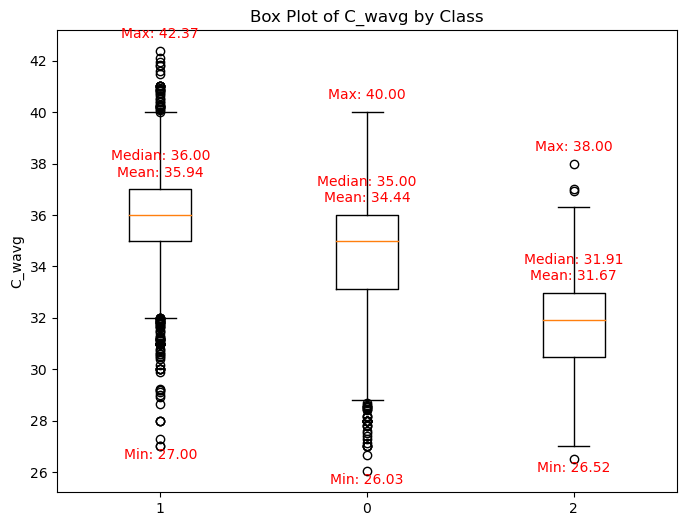

In [69]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'C_wavg')

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

def box_plot_by_class(data, class_column, value_column):
    # Extract the class and value columns
    class_values = data[class_column]
    value_values = data[value_column]

    # Create a dictionary to group the values by class
    values_by_class = {}
    for cls, val in zip(class_values, value_values):
        if cls not in values_by_class:
            values_by_class[cls] = []
        values_by_class[cls].append(val)

    # Calculate summary statistics for each class
    statistics = {}
    for cls, values in values_by_class.items():
        statistics[cls] = pd.Series(values).describe()

    # Set the figure size to a smaller dimension
    plt.figure(figsize=(8, 6))

    # Create the box plot
    temperature_data = list(values_by_class.values())
    plt.boxplot(temperature_data, patch_artist=True, notch=True)

    # Set the box plot colors
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']
    for patch, color in zip(plt.boxplot(temperature_data, patch_artist=True)['boxes'], colors):
        patch.set_facecolor(color)

    # Set the x-axis labels to the class names
    plt.xticks(range(1, len(values_by_class) + 1), values_by_class.keys())

    # Set the y-axis label
    plt.ylabel(value_column)

    # Set the plot title
    plt.title(f'Box Plot of {value_column} by Class')

    # Determine text position based on data scale
    min_value = min(value_values)
    max_value = max(value_values)
    range_value = max_value - min_value
    text_offset = range_value * 0.02  # Adjust the offset based on the data scale

    # Add the summary statistics to the plot
    for i, cls in enumerate(values_by_class.keys()):
        stat = statistics[cls]

        plt.text(i + 1, stat['75%'] + text_offset, f'Median: {stat["50%"]:.2f}',
                 horizontalalignment='center', color='black')

        plt.text(i + 1, stat['75%'] - text_offset, f'Q3: {stat["75%"]:.2f}',
                 horizontalalignment='center', color='black')

        plt.text(i + 1, stat['25%'] - text_offset, f'Q1: {stat["25%"]:.2f}',
                 horizontalalignment='center', color='black')

        plt.text(i + 1, stat['min'] - text_offset, f'Min: {stat["min"]:.2f}',
                 horizontalalignment='center', color='black')

        plt.text(i + 1, stat['max'] + text_offset, f'Max: {stat["max"]:.2f}',
                 horizontalalignment='center', color='black')

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()

    # Display the plot
    plt.show()


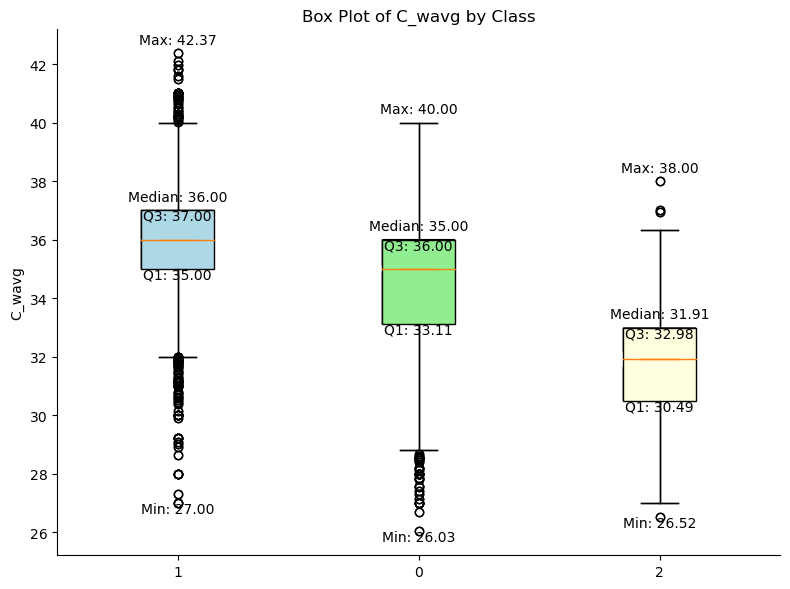

In [80]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'C_wavg')

## Plot Eaux

In [73]:
eaux_path = "./output_data/network/edges/edges_buffered_eaux_prop_bounding.gpkg"
eaux = gpd.read_file(eaux_path)
eaux = eaux.set_index(["u", "v", "key"])

In [74]:
sample_eaux = eaux.loc[sample_indices]
edges_all_prop["eaux_prop"] = sample_eaux["eaux_prop"]

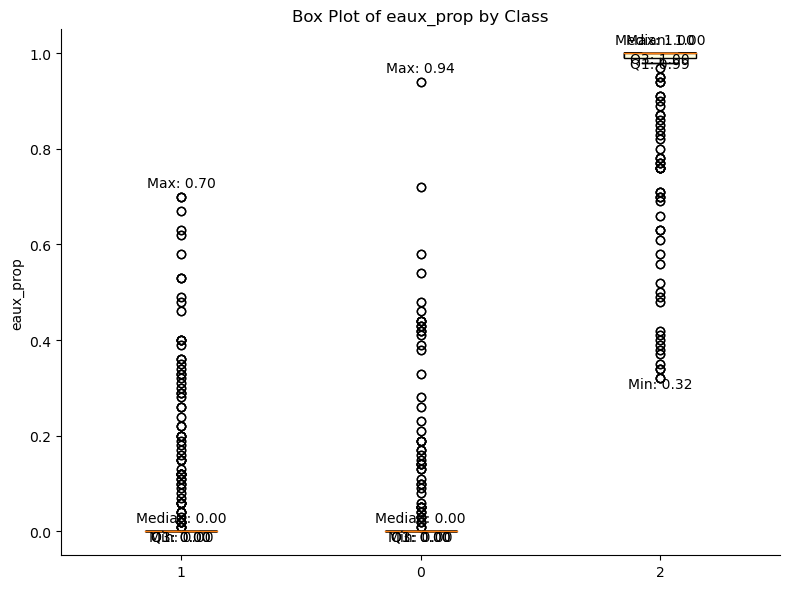

In [81]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'eaux_prop')

## Arbres

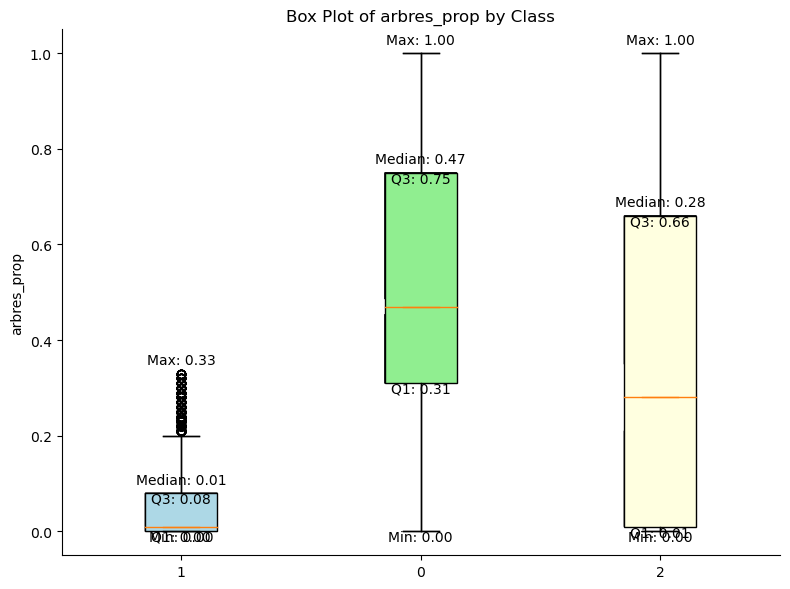

In [85]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'arbres_prop')

## Arbustes

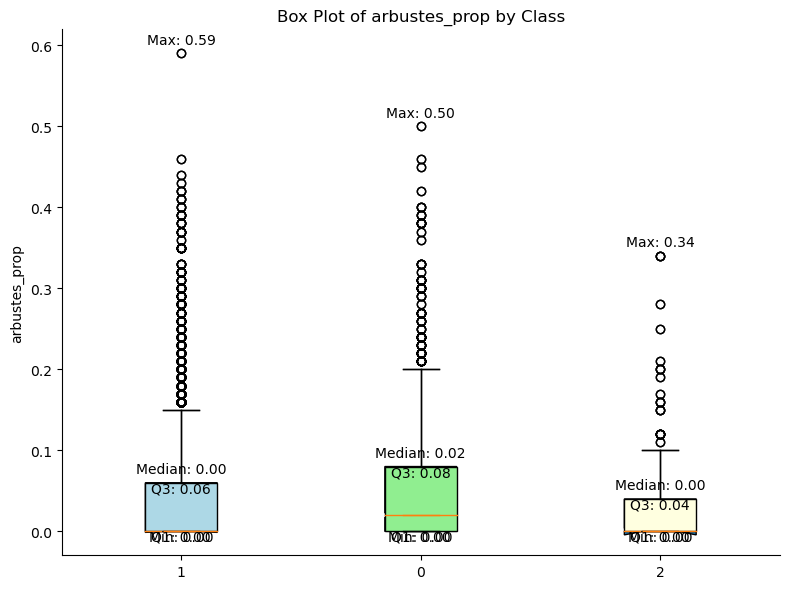

In [86]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'arbustes_prop')

## Prairies

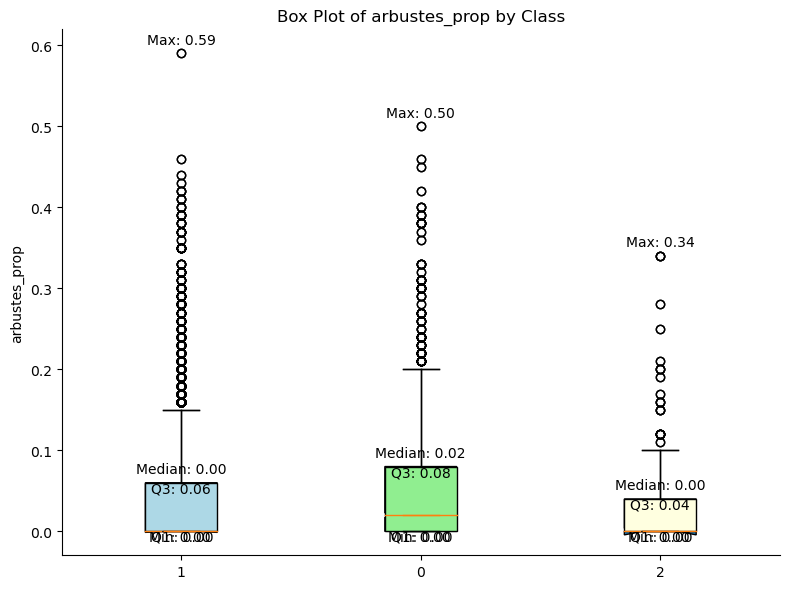

In [87]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'arbustes_prop')

## Canop

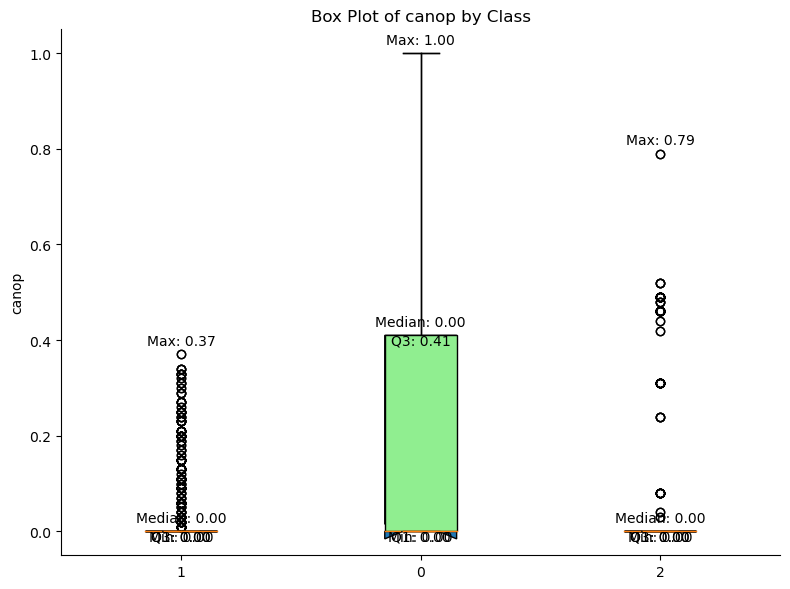

In [89]:
box_plot_by_class(edges_all_prop, 'hclust_classe', 'canop')

# ACP sur les scores

In [27]:
### SCRIPT ###
edges_all_score_path = "./output_data/network/edges/edges_buffered_total_score_distance_freshness_bounding.gpkg"
edges_all_score_output_path = "../../../score_calculation/sample_analyse/sample_data/edges_all_score_sample_hclust.gpkg"
edges_all_score = gpd.read_file(edges_all_score_path)

In [28]:
print(edges_all_score.columns)

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'score_prairies_prop', 'score_arbustes_prop', 'score_arbres_prop',
       'score_C_wavg_scaled', 'score_eaux_prop', 'score_canop', 'total_score',
       'exp_score_15', 'exp_score', 'length_scaled', 'score_scaled',
       'score_distance_scaled', 'score_distance', 'score_distance_prop',
       'score_sqrt', 'score_sqrt_0604', 'exp_distance', 'freshness_score',
       'exp_fresh_score', 'exp_fresh_score_15', 'geometry'],
      dtype='object')


In [32]:
edges_all_score = edges_all_score.reset_index().set_index(["u", "v", "key"])
edges_all_prop = edges_all_prop.reset_index().set_index(["u", "v", "key"])
sample_indices = edges_all_prop.index
edges_all_score_sample = edges_all_score.loc[sample_indices]
print(len(edges_all_score_sample))

8232


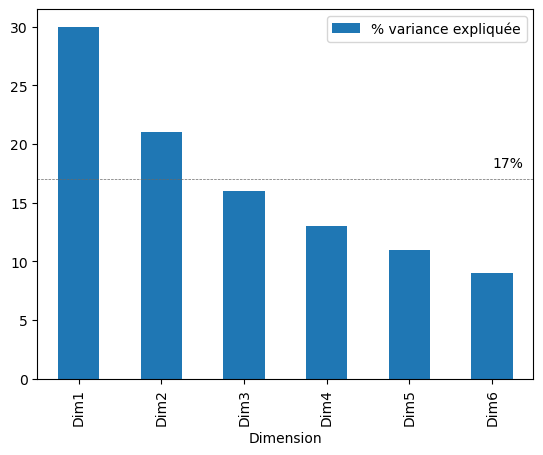

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            1.776507                  30.0                   30.0
1      Dim2            1.267228                  21.0                   51.0
2      Dim3            0.985160                  16.0                   67.0
3      Dim4            0.799718                  13.0                   80.0
4      Dim5            0.633279                  11.0                   91.0
5      Dim6            0.538836                   9.0                  100.0
8232


In [33]:
features_score = ["score_prairies_prop", "score_arbustes_prop", "score_arbres_prop", "score_C_wavg_scaled", "score_eaux_prop", "score_canop"]

score_pca = pca_pipeline(edges_all_score_sample, features_score, 6)
eig_score_pca = eigein_values(score_pca, plot=True)
coord_score = coord_pca(edges_all_score_sample[features_score], score_pca)
print(len(coord_score)) # 8232

Même résultats : mais logique car on a simplement une transformation linéaire des données avec le score.
Ne me semble pas pertinent de continuer l'analyse car on aura la même que pour les proportions.